In [164]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Загрузка данных
data_train = pd.read_csv("train.csv")


In [165]:
TRAIN_SPLIT = int(0.9 * len(data_train))
print(TRAIN_SPLIT)

8091


In [166]:
data_train.head()

,DateTime,Robot_X,Robot_Y,Robot_Angle,Ball_X,Ball_Y
0,09.02.2024 21:48:28,-0.049646,0.111455,-0.015986,0.075607,1.46080
1,09.02.2024 21:48:28,-0.049646,0.111455,-0.015971,0.075707,1.46080
2,09.02.2024 21:48:28,-0.239089,1.040000,-0.015955,0.075873,1.46167
3,09.02.2024 21:48:28,-0.101059,1.058200,-0.004182,0.070520,1.33220
4,09.02.2024 21:48:28,-0.101053,1.058080,-0.004240,0.070281,1.33212


In [167]:
import torch

torch.manual_seed(13)

In [168]:
features_considered = ['Robot_X', 'Robot_Y', 'Robot_Angle', 'Ball_X', 'Ball_Y']
features = data_train[features_considered]
features.index = data_train['DateTime']
features.head()


,Robot_X,Robot_Y,Robot_Angle,Ball_X,Ball_Y
DateTime,,,,,
09.02.2024 21:48:28,-0.049646,0.111455,-0.015986,0.075607,1.46080
09.02.2024 21:48:28,-0.049646,0.111455,-0.015971,0.075707,1.46080
09.02.2024 21:48:28,-0.239089,1.040000,-0.015955,0.075873,1.46167
09.02.2024 21:48:28,-0.101059,1.058200,-0.004182,0.070520,1.33220
09.02.2024 21:48:28,-0.101053,1.058080,-0.004240,0.070281,1.33212


In [169]:
dataset = features.values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)


In [40]:
dataset = (dataset-data_mean)/data_std


In [170]:
# Приведенная ниже функция возвращает вышеописанные временные интервалы для обучения модели. 
# @param: history_size — это размер последнего временного интервала,
# target_size – аргумент, определяющий насколько далеко в будущее модель должна научиться прогнозировать.
#  Другими словами, target_size – это целевой вектор, который необходимо спрогнозировать.

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [178]:
# У нас, в среднем, 11-12 записей каждую секунду, то есть примерно раз в 83 миллисекунды. Допустим, мы хотим прогнозировать на основе предыдущих 
#  10 секунд (36 измерений), положение тела через секунду (12) 

past_history = 120
future_target = 12
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 0:2], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 0:2],
                                                TRAIN_SPLIT, None, past_history,
                                                future_target, STEP,
                                                single_step=True)

In [179]:
BATCH_SIZE = 128

from torch.utils.data import TensorDataset, DataLoader

# Создание датасета
train_data_single = TensorDataset(torch.tensor(x_train_single).float(), torch.tensor(y_train_single).float())

# Создание DataLoader
train_loader_single = DataLoader(train_data_single, batch_size=BATCH_SIZE, shuffle=True)

val_data_single = TensorDataset(torch.tensor(x_val_single).float(), torch.tensor(y_val_single).float())

# Создание DataLoader
val_loader_single = DataLoader(val_data_single, batch_size=BATCH_SIZE, shuffle=False)



In [180]:
import torch.nn as nn

class SingleStepModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
        super(SingleStepModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 2*hidden_size)
        self.bn1 = nn.BatchNorm1d(2*hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(2*hidden_size, output_size)

    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        _, (hidden, _) = self.rnn(x)
        # hidden: (1, batch_size, hidden_size)
        out = self.fc1(hidden.squeeze(0))
        out = self.bn1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out


# Определение модели
input_size = x_train_single.shape[-1]
hidden_size = 32
output_size = 2
single_step_model = SingleStepModel(input_size, hidden_size, output_size)

# Определение функции потерь и оптимизатора
criterion =  nn.MSELoss()
optimizer =  torch.optim.Adam(single_step_model.parameters(), lr=0.001)

In [181]:
EPOCHS = 10

Epoch 1/10, Train Loss: 1.5124, Val Loss: 0.8954
Epoch 2/10, Train Loss: 1.0822, Val Loss: 0.5891
Epoch 3/10, Train Loss: 0.9900, Val Loss: 0.5943
Epoch 4/10, Train Loss: 0.9671, Val Loss: 0.6621
Epoch 5/10, Train Loss: 0.9191, Val Loss: 0.5039
Epoch 6/10, Train Loss: 0.8746, Val Loss: 0.5582
Epoch 7/10, Train Loss: 0.8467, Val Loss: 0.4806
Epoch 8/10, Train Loss: 0.8110, Val Loss: 0.4913
Epoch 9/10, Train Loss: 0.7921, Val Loss: 0.5345
Epoch 10/10, Train Loss: 0.7453, Val Loss: 0.4921


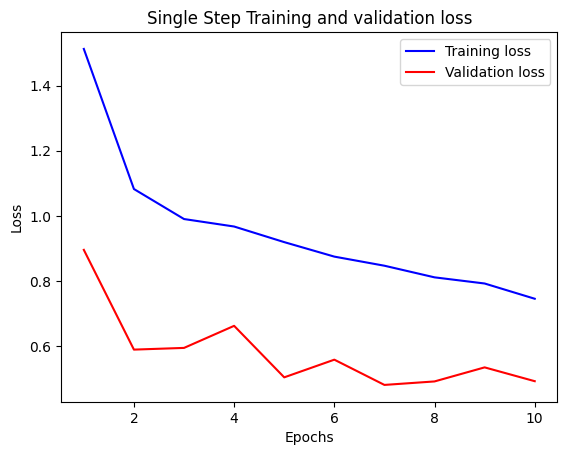

In [182]:
import torch
import matplotlib.pyplot as plt

import copy 

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_weights = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.float()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item() * inputs.size(0)
            epoch_val_loss = running_val_loss / len(val_loader.dataset)
            val_losses.append(epoch_val_loss)
        
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                best_model_weights = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')
    
    model.load_state_dict(best_model_weights)

    return train_losses, val_losses

def plot_train_history(train_losses, val_losses, title):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

train_losses, val_losses = train_model(single_step_model, train_loader_single, val_loader_single, criterion, optimizer, EPOCHS)
plot_train_history(train_losses, val_losses, 'Single Step Training and validation loss')

In [183]:
def predict(model, input_data):
    model.eval()

    with torch.no_grad():
        output = model(input_data)
    
    return output

<module 'matplotlib.pyplot' from '/home/gukas/work/.venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

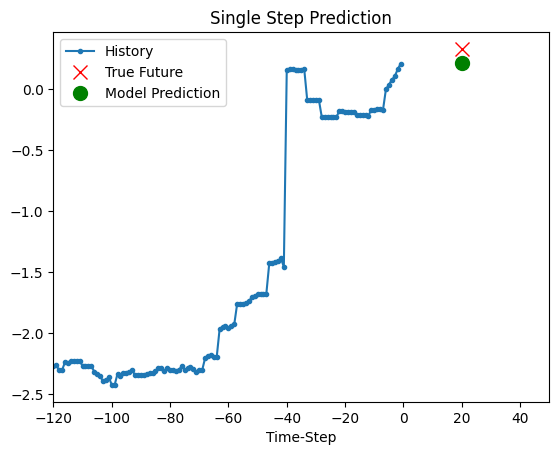

In [185]:
import torch
import matplotlib.pyplot as plt

def create_time_steps(length):
  return list(range(-length, 0))
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt


# Пример визуализации результатов для трех элементов из val_data_single

# Отображаем по Y координате:
x, y = val_data_single[0]

# Преобразовать тензоры PyTorch в массивы NumPy
x_np = x[:, 1].numpy()
y_np = y[1].numpy()

prediction = predict(single_step_model, x.unsqueeze(0)).squeeze(0)
prediction_np = (prediction.detach()[1].numpy())  # Преобразовать предсказания в NumPy массив

# Отобразить результаты
show_plot([x_np, y_np, prediction_np], 20, 'Single Step Prediction')


<module 'matplotlib.pyplot' from '/home/gukas/work/.venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

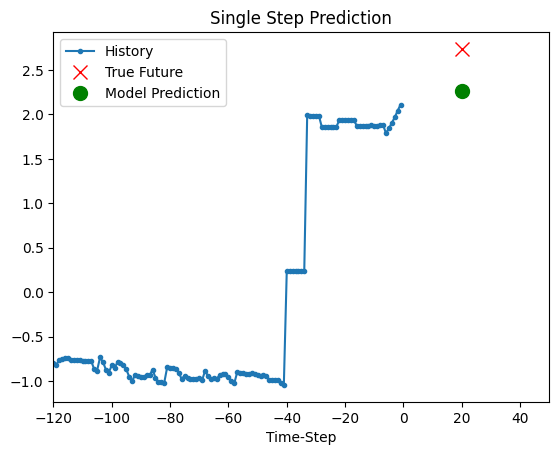

In [186]:
# Отображаем по X-координате:

# Преобразовать тензоры PyTorch в массивы NumPy
x_np = x[:, 0].numpy()
y_np = y[0].numpy()

prediction = predict(single_step_model, x.unsqueeze(0)).squeeze(0)
prediction_np = (prediction.detach()[0].numpy())  # Преобразовать предсказания в NumPy массив

# Отобразить результаты
show_plot([x_np, y_np, prediction_np], 20, 'Single Step Prediction')


In [187]:
data_test  = pd.read_csv("test.csv")
test_data = data_test[features_considered]
test_data.index = data_test['DateTime']
test_data = data_test[features_considered]
test_data.index = data_test['DateTime']
test_dataset = test_data.values
test_dataset = (test_dataset - data_mean) / data_std

x_test_single, y_test_single = multivariate_data(test_dataset, test_dataset[:, 0:2],
                                                0, None, past_history,
                                                future_target, STEP,
                                                single_step=True)


test_data_single = TensorDataset(torch.tensor(x_test_single).float(), torch.tensor(y_test_single).float())
test_loader_single = DataLoader(test_data_single, batch_size=BATCH_SIZE, shuffle=False)

def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.float()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
    avg_loss = total_loss / len(test_loader.dataset)
    return avg_loss

# Assuming test_loader_single contains the test data
test_loss = evaluate_model(single_step_model, test_loader_single, criterion)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.2585
